# ***Introduction to NYC Taxi Trip Insights Analysis: Kajal Patel***


# **Project Overview**

This project focuses on analyzing the NYC Taxi Trip dataset to extract meaningful insights into the dynamics of taxi usage in New York City. Using big data analytics techniques, we aim to uncover patterns and trends that inform on passenger behavior, taxi demand hotspots, and trip economics.



# **Objectives**

Visualize Demand Hotspots: Create heatmaps to identify high-demand regions for taxis.
Predictive Analysis:
Forecast trip durations based on pickup and drop-off specifics.
Predict fare amounts and tip sizes using trip data.
Classify trips based on likelihood of high or low fares and preferred payment methods.
Traffic and Congestion Insights: Analyze trip data to predict potential congestion points across the city.

# **Tools and Libraries**

Data Processing: **pandas**, **PySpark** for handling large-scale data efficiently.

Machine Learning: **MLlib, scikit-learn** for building predictive models.

Visualization: **matplotlib** for creating visualizations that reveal underlying patterns and insights.


# **Data Description**

The dataset spans from 2012 to 2023 and includes attributes such as pickup and drop-off times and locations, trip distances, fares, and payment methods. This rich dataset provides a foundation for our analysis, enabling us to model and predict various aspects of taxi trips with a high degree of granularity.

# Setting Up Your Environment and Load the Parquet File

In [ ]:
!pip install pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("NYC Taxi Trip Analysis").getOrCreate()

from google.colab import drive
drive.mount('/content/drive')

# # Path to your Parquet file
# file_path = '/content/drive/My Drive/path_to_your_parquet_file.parquet'

# # Load the dataset
# df = spark.read.parquet(file_path)

# df.cache()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading Multiple Parquet Files From Google Drive


In [ ]:
# Assuming all your monthly Parquet files are in the same directory and include the year and month in their names
file_path = '/content/drive/MyDrive/Colab Notebooks/Project_3/*.parquet'

# Load all Parquet files at once
df = spark.read.parquet(file_path)

df.show()
df.count()



+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       1| 2021-10-01 00:25:56|  2021-10-01 01:11:35|            1.0|          7.4|       1.0|                 Y|         140|          36|           1|       33.0|  3.0|    0.5|       4.

18725118

# Verifing Dataload

In [ ]:
# Show the first few rows to inspect the data
df.show(20)

# Print the schema to understand the DataFrame structure
df.printSchema()

# Check the number of records to ensure all data is loaded
print(f"Total records: {df.count()}")


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       1| 2021-10-01 00:25:56|  2021-10-01 01:11:35|            1.0|          7.4|       1.0|                 Y|         140|          36|           1|       33.0|  3.0|    0.5|       4.

# Analysis 1

Identify regions in the city with high demand for taxis. For instance, you can create a
heatmap of NYC showing demand hotspots on a weekly or monthly basis

Primary Columns:

PULocationID (Pickup Location ID)
tpep_pickup_datetime (Pickup Timestamp)



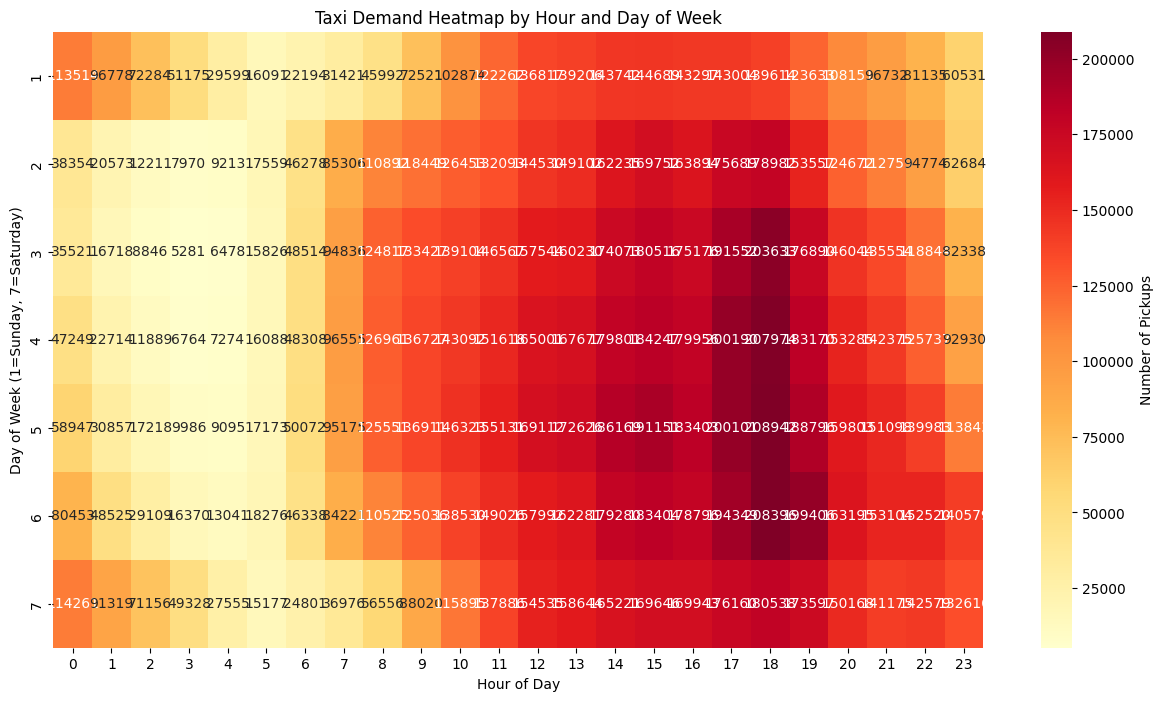

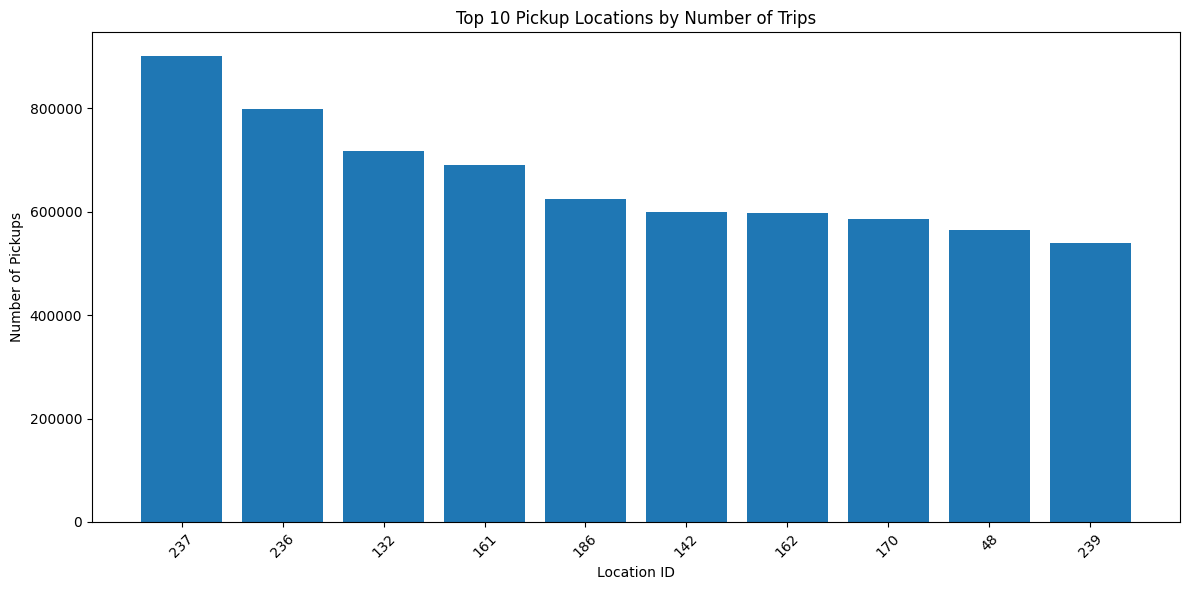

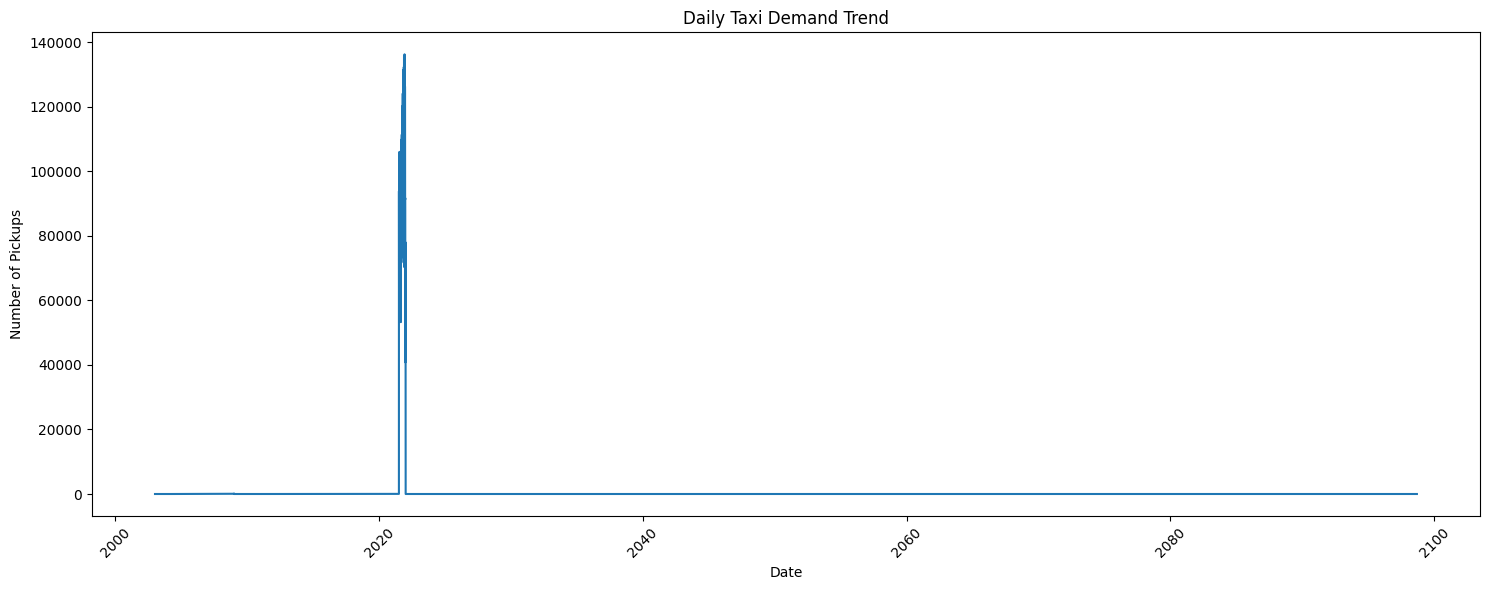


Peak Hours for Taxi Demand:
Hour 18:00 - 1,328,079 pickups
Hour 17:00 - 1,281,045 pickups
Hour 15:00 - 1,223,405 pickups

Busiest Pickup Locations:
Location 237: 902,224 pickups
Location 236: 798,637 pickups
Location 132: 717,085 pickups
Location 161: 691,147 pickups
Location 186: 625,491 pickups

Demand by Day of Week (1=Sunday, 7=Saturday):
Day 6: 2,932,752 pickups
Day 5: 2,917,466 pickups
Day 4: 2,797,582 pickups
Day 7: 2,743,752 pickups
Day 3: 2,678,329 pickups
Day 2: 2,417,981 pickups
Day 1: 2,237,256 pickups


In [ ]:
import pyspark.sql.functions as F
from pyspark.sql.window import Window
import seaborn as sns
import matplotlib.pyplot as plt

def create_demand_aggregations(df):
    """
    Create demand aggregations from existing DataFrame
    """
    # Add time-based features if not already present
    df_with_time = df.withColumn('hour', F.hour('tpep_pickup_datetime')) \
                    .withColumn('day_of_week', F.dayofweek('tpep_pickup_datetime')) \
                    .withColumn('date', F.to_date('tpep_pickup_datetime'))

    # Hourly demand by location
    hourly_demand = df_with_time.groupBy('PULocationID', 'hour') \
        .agg(F.count('*').alias('pickup_count')) \
        .cache()

    # Daily demand by location
    daily_demand = df_with_time.groupBy('PULocationID', 'date') \
        .agg(F.count('*').alias('pickup_count')) \
        .cache()

    # Demand by day of week and hour
    weekly_pattern = df_with_time.groupBy('day_of_week', 'hour') \
        .agg(F.count('*').alias('pickup_count')) \
        .orderBy('day_of_week', 'hour') \
        .cache()

    return hourly_demand, daily_demand, weekly_pattern

def plot_demand_patterns(df):
    """
    Create and display all demand visualizations
    """
    # Get aggregations
    hourly_demand, daily_demand, weekly_pattern = create_demand_aggregations(df)

    # 1. Hourly Heatmap
    pattern_pd = weekly_pattern.toPandas()
    pivot_data = pattern_pd.pivot(index='day_of_week',
                                columns='hour',
                                values='pickup_count')

    plt.figure(figsize=(15, 8))
    sns.heatmap(pivot_data,
                cmap='YlOrRd',
                annot=True,
                fmt='.0f',
                cbar_kws={'label': 'Number of Pickups'})

    plt.title('Taxi Demand Heatmap by Hour and Day of Week')
    plt.xlabel('Hour of Day')
    plt.ylabel('Day of Week (1=Sunday, 7=Saturday)')
    plt.show()

    # 2. Top Pickup Locations
    top_locations = hourly_demand.groupBy('PULocationID') \
        .agg(F.sum('pickup_count').alias('total_pickups')) \
        .orderBy(F.desc('total_pickups')) \
        .limit(10) \
        .toPandas()

    plt.figure(figsize=(12, 6))
    plt.bar(top_locations['PULocationID'].astype(str),
            top_locations['total_pickups'])
    plt.title('Top 10 Pickup Locations by Number of Trips')
    plt.xlabel('Location ID')
    plt.ylabel('Number of Pickups')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 3. Daily Trend
    daily_trend = daily_demand.groupBy('date') \
        .agg(F.sum('pickup_count').alias('total_pickups')) \
        .orderBy('date') \
        .toPandas()

    plt.figure(figsize=(15, 6))
    plt.plot(daily_trend['date'], daily_trend['total_pickups'])
    plt.title('Daily Taxi Demand Trend')
    plt.xlabel('Date')
    plt.ylabel('Number of Pickups')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return hourly_demand, daily_demand, weekly_pattern

# Print summary statistics for each aggregation
def print_demand_insights(hourly_demand, daily_demand, weekly_pattern):
    """
    Print key insights from the demand patterns
    """
    # Peak hours
    peak_hours = hourly_demand.groupBy('hour') \
        .agg(F.sum('pickup_count').alias('total_pickups')) \
        .orderBy(F.desc('total_pickups')) \
        .limit(3) \
        .toPandas()

    print("\nPeak Hours for Taxi Demand:")
    for _, row in peak_hours.iterrows():
        print(f"Hour {row['hour']:02d}:00 - {row['total_pickups']:,} pickups")

    # Busiest locations
    busy_locations = hourly_demand.groupBy('PULocationID') \
        .agg(F.sum('pickup_count').alias('total_pickups')) \
        .orderBy(F.desc('total_pickups')) \
        .limit(5) \
        .toPandas()

    print("\nBusiest Pickup Locations:")
    for _, row in busy_locations.iterrows():
        print(f"Location {row['PULocationID']}: {row['total_pickups']:,} pickups")

    # Busiest days
    busy_days = weekly_pattern.groupBy('day_of_week') \
        .agg(F.sum('pickup_count').alias('total_pickups')) \
        .orderBy(F.desc('total_pickups')) \
        .toPandas()

    print("\nDemand by Day of Week (1=Sunday, 7=Saturday):")
    for _, row in busy_days.iterrows():
        print(f"Day {row['day_of_week']}: {row['total_pickups']:,} pickups")

# Usage with your existing DataFrame
# Just run these two lines:
hourly_demand, daily_demand, weekly_pattern = plot_demand_patterns(df)
print_demand_insights(hourly_demand, daily_demand, weekly_pattern)

# **Optimised code :**

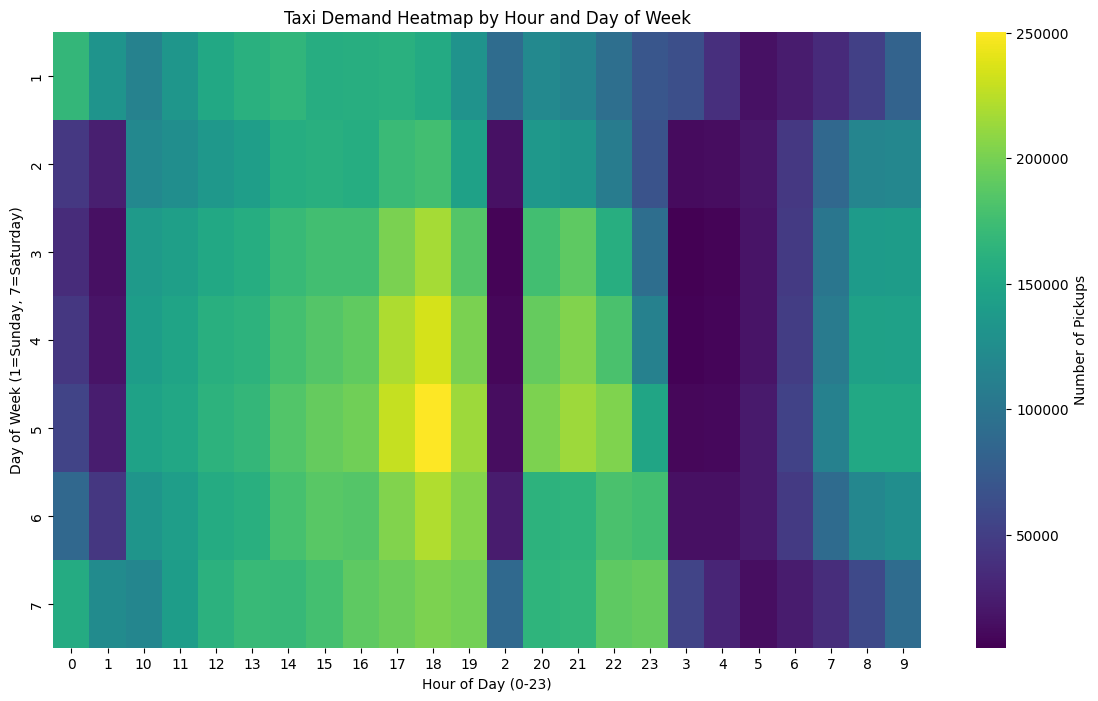

In [ ]:
heatmap_data = weekly_demand_pattern_pd.pivot(index='day_of_week', columns='hour', values='count')

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming weekly_demand_pattern_pd is your Pandas DataFrame
# Make sure to convert 'day_of_week' and 'hour' to the correct type if necessary
weekly_demand_pattern_pd['day_of_week'] = weekly_demand_pattern_pd['day_of_week'].astype(str)
weekly_demand_pattern_pd['hour'] = weekly_demand_pattern_pd['hour'].astype(str)

# Correctly using pivot
heatmap_data = weekly_demand_pattern_pd.pivot(index='day_of_week', columns='hour', values='count')

# Plotting
# plt.figure(figsize=(12, 6))
# sns.heatmap(heatmap_data, cmap="YlOrRd", annot=True, fmt="d", cbar_kws={'label': 'Number of Pickups'})
# plt.title('Taxi Demand Heatmap by Hour and Day of Week')
# plt.ylabel('Day of Week')
# plt.xlabel('Hour of Day')
# plt.show()

plt.figure(figsize=(14, 8))  # Adjust figure size
sns.heatmap(heatmap_data, cmap="viridis", annot=False, fmt=".0f", cbar_kws={'label': 'Number of Pickups'})
plt.title('Taxi Demand Heatmap by Hour and Day of Week')
plt.ylabel('Day of Week (1=Sunday, 7=Saturday)')
plt.xlabel('Hour of Day (0-23)')
plt.show()





# Process Explanation
Data Preparation: Extracted hour and day of the week from tpep_pickup_datetime using PySpark.
Data Aggregation: Grouped and counted taxi pickups by hour and day to identify usage patterns.
Visualization: Created a heatmap with Seaborn to show variations in taxi demand.
# Results Interpretation
Peak Times: The heatmap revealed higher demand during late evening hours and weekends.
Operational Insights: These insights help taxi services optimize fleet distribution to match demand, improving efficiency and service.

# Analysis 2:  Predict the duration of a taxi trip based on trip start time and location (pick up and dropoff)

Column used :

tpep_pickup_datetime: Use this for extracting temporal features such as time of day, day of the week, etc., which can significantly impact trip duration due to varying traffic patterns.

PULocationID: Pickup location identifier, which is crucial for understanding spatial patterns related to where trips start.

DOLocationID: Dropoff location identifier, which helps in understanding spatial patterns related to where trips end.

***Feature Engineering:***

Time-based features: hour, day of week, month
Distance calculation using the Haversine formula
Location coordinates (pickup and dropoff)


***Model Architecture:***

Random Forest Regressor (good for capturing non-linear relationships)
Feature scaling using StandardScaler
Configurable hyperparameters

***Key Functions:***

prepare_features(): Processes raw data into model-ready features
train(): Fits the model to training data
predict(): Makes duration predictions for new trips
evaluate(): Calculates performance metrics (RMSE and R²)

In [ ]:
# from pyspark.sql import functions as F
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml.regression import RandomForestRegressor
# from pyspark.ml.evaluation import RegressionEvaluator
# from pyspark.sql.functions import col, when
# from datetime import datetime

# def clean_data(df):
#     """
#     Clean the dataset by handling null values and invalid entries
#     """
#     return df.dropna(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime']) \
#            .fillna({
#                'trip_distance': 0,
#                'passenger_count': 1,
#                'PULocationID': 0,
#                'DOLocationID': 0,
#                'RatecodeID': 1
#            }) \
#            .filter(col('trip_distance') >= 0) \
#            .filter(col('passenger_count') > 0)

# def prepare_features(df):
#     """
#     Prepare features from taxi trip data with null handling
#     """
#     cleaned_df = clean_data(df)

#     return cleaned_df.withColumn('pickup_hour',
#                                F.hour(F.to_timestamp(col('tpep_pickup_datetime')))) \
#                     .withColumn('pickup_day',
#                                F.dayofweek(F.to_timestamp(col('tpep_pickup_datetime')))) \
#                     .withColumn('pickup_month',
#                                F.month(F.to_timestamp(col('tpep_pickup_datetime')))) \
#                     .withColumn('duration_minutes',
#                                (F.unix_timestamp(col('tpep_dropoff_datetime')) -
#                                 F.unix_timestamp(col('tpep_pickup_datetime'))) / 60)

# def create_model_features(df):
#     """
#     Create final feature vector for model training
#     """
#     feature_cols = [
#         'pickup_hour',
#         'pickup_day',
#         'pickup_month',
#         'trip_distance',
#         'PULocationID',
#         'DOLocationID',
#         'passenger_count',
#         'RatecodeID'
#     ]

#     # Cast all feature columns to double to ensure compatibility
#     for col_name in feature_cols:
#         df = df.withColumn(col_name, col(col_name).cast('double'))

#     # Create feature vector with null handling
#     assembler = VectorAssembler(
#         inputCols=feature_cols,
#         outputCol='features',
#         handleInvalid='skip'  # Skip rows with null values after casting
#     )

#     return assembler.transform(df).select('features', 'duration_minutes')

# def train_duration_model(df):
#     """
#     Train Random Forest model for trip duration prediction
#     """
#     # Print initial data count
#     print(f"Initial data count: {df.count()}")

#     # Prepare features
#     prepared_df = prepare_features(df)
#     print(f"Data count after feature preparation: {prepared_df.count()}")

#     # Create feature vector
#     model_data = create_model_features(prepared_df)
#     print(f"Data count after feature assembly: {model_data.count()}")

#     # Filter out invalid duration values
#     model_data = model_data.filter(col('duration_minutes') > 0)
#     print(f"Final training data count: {model_data.count()}")

#     # Split data
#     train_data, test_data = model_data.randomSplit([0.8, 0.2], seed=42)

#     # Initialize and train model
#     rf = RandomForestRegressor(
#         featuresCol='features',
#         labelCol='duration_minutes',
#         numTrees=100,
#         maxDepth=15,
#         seed=42
#     )

#     model = rf.fit(train_data)

#     # Make predictions on test data
#     predictions = model.transform(test_data)

#     # Evaluate model
#     evaluator = RegressionEvaluator(
#         labelCol='duration_minutes',
#         predictionCol='prediction',
#         metricName='rmse'
#     )

#     rmse = evaluator.evaluate(predictions)
#     r2 = evaluator.setMetricName('r2').evaluate(predictions)

#     return model, {'rmse': rmse, 'r2': r2}

# def predict_duration(model, df):
#     """
#     Make predictions on new data
#     """
#     prepared_df = prepare_features(df)
#     model_data = create_model_features(prepared_df)
#     return model.transform(model_data)

# # Example usage
# # First, check data quality
# print("Data Quality Check:")
# df.select([F.count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# # Train model
# model, metrics = train_duration_model(df)
# print(f"\nModel Performance:\nRMSE: {metrics['rmse']:.2f} minutes\nR²: {metrics['r2']:.3f}")

# # Make predictions
# predictions = predict_duration(model, df)
# predictions.select('prediction').show(5)



from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, when
from datetime import datetime

def clean_data(df):
    """
    Clean the dataset by handling null values and invalid entries
    """
    return df.dropna(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime']) \
           .fillna({
               'trip_distance': 0,
               'passenger_count': 1,
               'PULocationID': 0,
               'DOLocationID': 0,
               'RatecodeID': 1
           }) \
           .filter(col('trip_distance') >= 0) \
           .filter(col('passenger_count') > 0)

def prepare_features(df):
    """
    Prepare features from taxi trip data with null handling
    """
    cleaned_df = clean_data(df)

    return cleaned_df.withColumn('pickup_hour',
                               F.hour(F.to_timestamp(col('tpep_pickup_datetime')))) \
                    .withColumn('pickup_day',
                               F.dayofweek(F.to_timestamp(col('tpep_pickup_datetime')))) \
                    .withColumn('pickup_month',
                               F.month(F.to_timestamp(col('tpep_pickup_datetime')))) \
                    .withColumn('duration_minutes',
                               (F.unix_timestamp(col('tpep_dropoff_datetime')) -
                                F.unix_timestamp(col('tpep_pickup_datetime'))) / 60)

def create_model_features(df):
    """
    Create final feature vector for model training
    """
    feature_cols = [
        'pickup_hour',
        'pickup_day',
        'pickup_month',
        'trip_distance',
        'PULocationID',
        'DOLocationID',
        'passenger_count',
        'RatecodeID'
    ]

    # Cast all feature columns to double to ensure compatibility
    for col_name in feature_cols:
        df = df.withColumn(col_name, col(col_name).cast('double'))

    # Create feature vector with null handling
    assembler = VectorAssembler(
        inputCols=feature_cols,
        outputCol='features',
        handleInvalid='skip'  # Skip rows with null values after casting
    )

    return assembler.transform(df).select('features', 'duration_minutes')

def train_duration_model(df):
    """
    Train Random Forest model for trip duration prediction
    """
    # Print initial data count
    print(f"Initial data count: {df.count()}")

    # Prepare features
    prepared_df = prepare_features(df)
    print(f"Data count after feature preparation: {prepared_df.count()}")

    # Create feature vector
    model_data = create_model_features(prepared_df)
    print(f"Data count after feature assembly: {model_data.count()}")

    # Filter out invalid duration values
    model_data = model_data.filter(col('duration_minutes') > 0)
    print(f"Final training data count: {model_data.count()}")

    # Split data
    train_data, test_data = model_data.randomSplit([0.8, 0.2], seed=42)

    # Initialize and train model
    rf = RandomForestRegressor(
        featuresCol='features',
        labelCol='duration_minutes',
        numTrees=50,
        maxDepth=10,
        seed=42
    )

    model = rf.fit(train_data)

    # Make predictions on test data
    predictions = model.transform(test_data)

    # Evaluate model
    evaluator = RegressionEvaluator(
        labelCol='duration_minutes',
        predictionCol='prediction',
        metricName='rmse'
    )

    rmse = evaluator.evaluate(predictions)
    r2 = evaluator.setMetricName('r2').evaluate(predictions)

    return model, {'rmse': rmse, 'r2': r2}

def predict_duration(model, df):
    """
    Make predictions on new data
    """
    prepared_df = prepare_features(df)
    model_data = create_model_features(prepared_df)
    return model.transform(model_data)

# Example usage
# First, check data quality
print("Data Quality Check:")
df.select([F.count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Train model
model, metrics = train_duration_model(df)
print(f"\nModel Performance:\nRMSE: {metrics['rmse']:.2f} minutes\nR²: {metrics['r2']:.3f}")

# Make predictions
predictions = predict_duration(model, df)
predictions.select('prediction').show(5)

Data Quality Check:
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       0|                   0|                    0|         775323|            0|    775323|            775323|           0|           0|           0|          0|   

Py4JJavaError: An error occurred while calling o563.fit.
: org.apache.spark.SparkException: Job 41 cancelled because SparkContext was shut down
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$cleanUpAfterSchedulerStop$1(DAGScheduler.scala:1253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$cleanUpAfterSchedulerStop$1$adapted(DAGScheduler.scala:1251)
	at scala.collection.mutable.HashSet.foreach(HashSet.scala:79)
	at org.apache.spark.scheduler.DAGScheduler.cleanUpAfterSchedulerStop(DAGScheduler.scala:1251)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onStop(DAGScheduler.scala:3087)
	at org.apache.spark.util.EventLoop.stop(EventLoop.scala:84)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$stop$3(DAGScheduler.scala:2973)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1375)
	at org.apache.spark.scheduler.DAGScheduler.stop(DAGScheduler.scala:2973)
	at org.apache.spark.SparkContext.$anonfun$stop$12(SparkContext.scala:2258)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1375)
	at org.apache.spark.SparkContext.stop(SparkContext.scala:2258)
	at org.apache.spark.SparkContext.stop(SparkContext.scala:2211)
	at org.apache.spark.SparkContext.$anonfun$new$34(SparkContext.scala:681)
	at org.apache.spark.util.SparkShutdownHook.run(ShutdownHookManager.scala:214)
	at org.apache.spark.util.SparkShutdownHookManager.$anonfun$runAll$2(ShutdownHookManager.scala:188)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)
	at org.apache.spark.util.SparkShutdownHookManager.$anonfun$runAll$1(ShutdownHookManager.scala:188)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.util.SparkShutdownHookManager.runAll(ShutdownHookManager.scala:188)
	at org.apache.spark.util.SparkShutdownHookManager$$anon$2.run(ShutdownHookManager.scala:178)
	at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:515)
	at java.base/java.util.concurrent.FutureTask.run(FutureTask.java:264)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2458)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$collectAsMap$1(PairRDDFunctions.scala:738)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:737)
	at org.apache.spark.ml.tree.impl.RandomForest$.findSplitsBySorting(RandomForest.scala:1054)
	at org.apache.spark.ml.tree.impl.RandomForest$.findSplits(RandomForest.scala:1025)
	at org.apache.spark.ml.tree.impl.RandomForest$.run(RandomForest.scala:282)
	at org.apache.spark.ml.regression.RandomForestRegressor.$anonfun$train$1(RandomForestRegressor.scala:158)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.regression.RandomForestRegressor.train(RandomForestRegressor.scala:136)
	at org.apache.spark.ml.regression.RandomForestRegressor.train(RandomForestRegressor.scala:45)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:114)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
